# 04. Pytorch Custom Datasets Video Notebook


## 0 Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

torch.__version__

'1.12.1'

In [2]:
# setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get data

Our dataset is subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class(750 training, 250 testing)

Our dataset start with 3 classes of food and only 10% of the images (~75 training, 25 testing)

Why do this ?

When starting out ML Projects, it's important to try things on a small scale then increase the scale when necessary.

The whole point is to speed up how fast you can experiment.

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path/ "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory already exists.... skipping download")
else:
    print(f"{image_path} does not exist, creating one.....")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download pizza, steak and sushi data
with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data......")
    f.write(request.content)
# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    zip_ref.extractall(image_path)

data\pizza_steak_sushi directory already exists.... skipping download


## 2. Becoming one with the data (data preparation and data exploration)

In [4]:
import os
def walk_through_dir(dir_path):
    """Walks through dir_path retuning its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [6]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

###  2.1 Visualizing and image

Let's write some code to:

    1. Get all of the image paths
    
    2. Pick a random image path using Python's random.choice()
    
    3. Get the image class with using **pathlib.Path.parent.stem**
    
    4. Since we are working with images, let's open the image with Pyton's PIL
    
    5. We'll then show the image and print metadata

Random image path: data\pizza_steak_sushi\test\sushi\858157.jpg
Image class: sushi
Image height: 288
Image width: 512


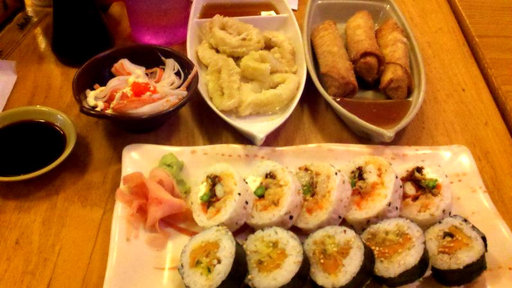

In [7]:
import random
from PIL import Image

# random seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
# print(random_image_path)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
# print(image_class)

# 4. open image with PIL
img = Image.open(random_image_path)

# 5. print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

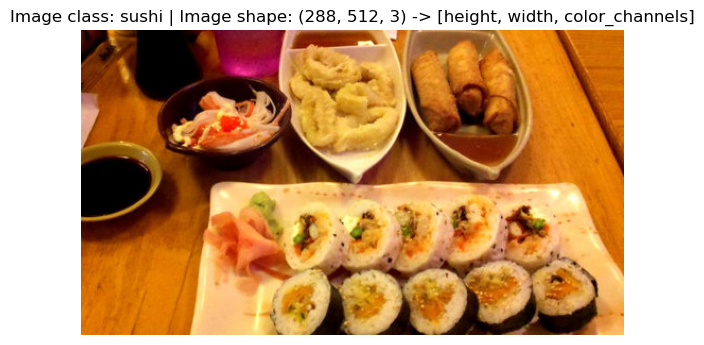

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib 
plt.figure(figsize=(7,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [9]:
img_as_array

array([[[ 86,  18,   5],
        [ 76,  14,   3],
        [ 57,   7,   0],
        ...,
        [214, 114,   0],
        [219, 115,   2],
        [220, 114,   2]],

       [[ 79,  13,   0],
        [ 69,   9,   0],
        [ 52,   3,   0],
        ...,
        [213, 112,   4],
        [215, 113,   5],
        [213, 111,   3]],

       [[ 76,  14,   0],
        [ 68,  10,   0],
        [ 51,   4,   0],
        ...,
        [210, 112,   5],
        [211, 110,   6],
        [209, 108,   4]],

       ...,

       [[221, 121,   1],
        [227, 124,   3],
        [225, 122,   1],
        ...,
        [253, 190,  97],
        [253, 190,  95],
        [253, 190,  93]],

       [[224, 124,   2],
        [230, 128,   4],
        [227, 125,   1],
        ...,
        [253, 192,  99],
        [253, 193,  95],
        [253, 194,  94]],

       [[223, 123,   0],
        [229, 127,   3],
        [226, 124,   0],
        ...,
        [254, 193, 102],
        [254, 194,  96],
        [253, 195,  95]]

## 3. Transforming data

Before we can use our data with PyTorch:

    1. Turn your target data into tensors(in our case, numerical representation of our images).
    2. Turn it into a **torch.utils.data.Dataset** and subsequently a **torch.utils.data.DataLoader** we'll call these **Dataset** and **DataLoader**.

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with torchvision.transforms

In [11]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our image to 64x64
    transforms.Resize(size=(64,64)),
    # Flip the image randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [12]:
data_transform(img)

tensor([[[0.2000, 0.2431, 0.1804,  ..., 0.8353, 0.8275, 0.8196],
         [0.1608, 0.1804, 0.1373,  ..., 0.8157, 0.8078, 0.7961],
         [0.1882, 0.1137, 0.1608,  ..., 0.8118, 0.8039, 0.7961],
         ...,
         [0.8667, 0.8745, 0.8588,  ..., 0.8745, 0.9216, 0.9725],
         [0.8667, 0.8706, 0.8510,  ..., 0.9059, 0.9569, 0.9922],
         [0.8745, 0.8667, 0.8588,  ..., 0.9529, 0.9882, 0.9922]],

        [[0.0353, 0.0314, 0.0431,  ..., 0.4392, 0.4392, 0.4392],
         [0.0275, 0.0118, 0.0314,  ..., 0.4196, 0.4157, 0.4078],
         [0.0275, 0.0039, 0.0510,  ..., 0.4157, 0.4078, 0.4039],
         ...,
         [0.4510, 0.4588, 0.4392,  ..., 0.5490, 0.6118, 0.6706],
         [0.4549, 0.4510, 0.4314,  ..., 0.6039, 0.6706, 0.7098],
         [0.4667, 0.4510, 0.4392,  ..., 0.6863, 0.7176, 0.7412]],

        [[0.0078, 0.0078, 0.0078,  ..., 0.0196, 0.0039, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0118, 0.0078, 0.0118],
         [0.0078, 0.0039, 0.0118,  ..., 0.0118, 0.0118, 0.

In [13]:
def plot_transforms_image(image_paths: list, transform, n=3, seed=None):
    """
    Select random images from a path of images and loads/transforms
    them then plots the orignial vs the transformed version.
    """
    if seed:
        random.seed(seed)
        
    random_image_paths = random.sample(image_paths, k=n)
    for i in random_image_paths:
        with Image.open(i) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)
            
            # Transform and plot target image
            transformed_image = transform(f).permute(1,2,0)  # note we will need to change shape for matplotlib(C, H, W) -> (H, W, C)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis(False)
            
            fig.suptitle(f"Class: {i.parent.stem}", fontsize=16)

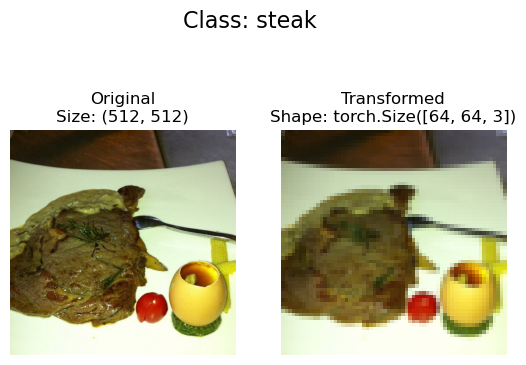

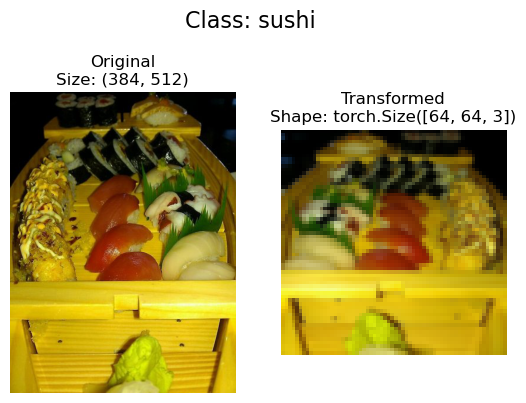

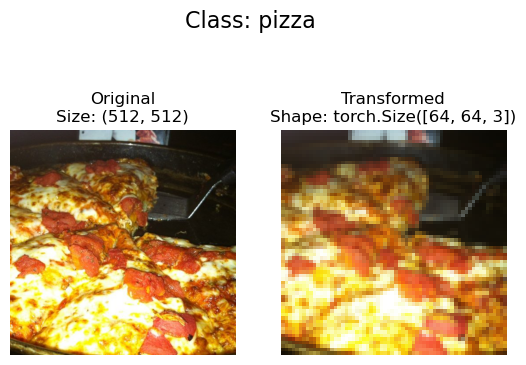

In [14]:
plot_transforms_image(image_paths=image_path_list,
                      transform=data_transform,
                      n=3,
                      seed=None)

## 4. Option 1: Loading image data using 'ImageFolder'

we can load image classificaion data using **torchvision.datasets.ImageFolder** 

In [15]:
# Use ImageFolder to create datasets
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,  # a transform for the data
                                  target_transform=None)    # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)  # a transform for the test data

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [16]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [17]:
# class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [18]:
# Index on the train_data Datasets to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Originla shape: torch.Size([3, 64, 64]) -> [c, h, w]
Image permute: torch.Size([64, 64, 3]) -> [h, w, c]


Text(0.5, 1.0, 'pizza')

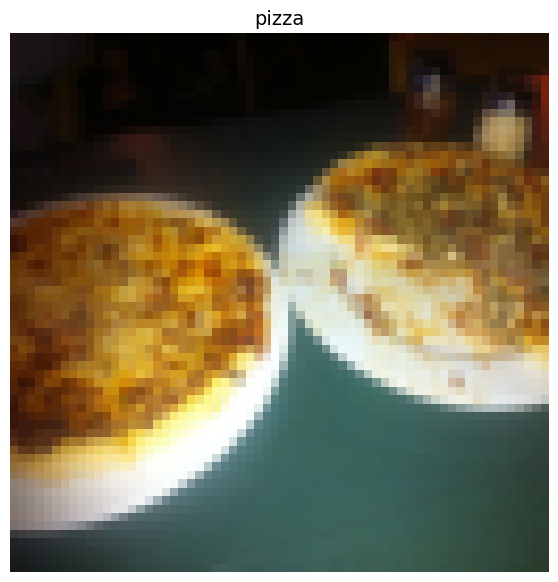

In [19]:
# Rearrange the order dimensions
img_permute = img.permute(1,2,0)

# Print out different shape
print(f"Originla shape: {img.shape} -> [c, h, w]")
print(f"Image permute: {img_permute.shape} -> [h, w, c]")

# Plot the image 
plt.figure(figsize=(7, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

### 4.1 Turn loaded images into 'DataLoader' 

A 'DataLoader' is going to help us turn our 'Dataset' into iterables and we can customise the **'batch_size'** so our model can see **'batch_size'** images at a time.

In [20]:
import os
os.cpu_count()

2

In [21]:
# turn train and test datasets into DataLoader's 
from torch.utils.data import DataLoader

BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,       # num of CPUs -> os.cpu_count()
                               shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1a18fd48a00>,
 <torch.utils.data.dataloader.DataLoader at 0x1a18fd484c0>)

In [22]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [23]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch if you like 
print(f"Image shape: {img.shape} -> [batch_size, c, h, w]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, c, h, w]
Label shape: torch.Size([1])


## 5 Option 2: Loading Image Data with a custom 'Dataset' (high level overview)

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from Dataset

pros:
* Can create a Dataset out of almost anyting
* Not limited to Pytorch pre-built **Dataset** function

cons:
* Even through you could create Dataset out of anyting, it doesn't mean it will work...
* Using a custom Dataset often results in us writing more code, which could be prone to errors or performance issues



In [24]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [25]:
# Instance of torchvision.dataset.ImgeFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## 5.1 Creating a helper function to get class names

We want a function to:
    
    1. Get the class names using os.scandir() to traverse a target directory (ideally the directory is in standard image classification format).
    
    2. Raise an error if the class names aren't found (if thsi happens, there might be someting wrong the directory sturcture)
    3. Turn the class names into a dict and list and return them. 

In [26]:
# Setup path for target directory 
target_directory = train_dir
print(f"Train dir: {target_directory}")

# Get the class names from the target directory 
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Train dir: data\pizza_steak_sushi\train


['pizza', 'steak', 'sushi']

In [27]:
list(os.scandir(target_directory))

[<DirEntry 'pizza'>, <DirEntry 'steak'>, <DirEntry 'sushi'>]

In [28]:
def find_classes(diretory: str) -> Tuple[List[str], Dict[str, int]]:
    """Find the class folder names in a target directory."""
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in list(os.scandir(diretory)) if entry.is_dir())
    
    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Could't find any classes in {directory}... please check file structure.")
    
    # 3. Create a directory of index labels
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx


In [29]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom Dataset to replicate ImageFolder (high level overview)

To create torch.utils.data.Dataset
    
    1. Subclass torch.utils.data.Dataset
    2. Init our subclass with a target directory (the directory we'd like to get data from) as well as transform if we'd like to transform our data.
    3. Create several attributs:
        * path - paths of our images
        * transform - the transform we'd like to use 
        * classes- a list of the target classes
        * class_to_idx - a dict of the target classes mapped to integer labels
    4. Create a function to **load_images()** , this function will open an image
    5. Overwrite the **__len()__** method to return the length of our dataset
    6. Overwrite the **__getitem()__** method to return a given sample when passed an index

In [30]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialize our custom dataset
    def __init__(self, targ_dir: str, transform=None):
        
        # 3. Create class attributes
        # Get all of the image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # Setup transform
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)
        
    # 4. Create a function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)
    
    # 5. Overwrite __len__()
    def __len__(self)-> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite __getitem__() method to return a particular sample
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # expect path fromat: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]
        
        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X,y)
        else:
            return img, class_idx  # return untransformed image and label
        

In [31]:
# Create a transform
from torchvision import transforms

train_transforms = transforms.Compose([
                                        transforms.Resize(size=(64, 64)),
                                        transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.ToTensor()
])

test_transforms = transforms.Compose([
                                        transforms.Resize(size=(64, 64)),
                                        transforms.ToTensor()
])

In [32]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [33]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x1a19209f8b0>,
 <__main__.ImageFolderCustom at 0x1a19209f760>)

In [34]:
len(train_data), len(train_data_custom)

(225, 225)

In [35]:
len(test_data), len(test_data_custom)

(75, 75)

In [36]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [37]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [38]:
# Check for quality between original ImageFolder Dataset and ImageFolderCustomDataset
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a 'Dataset' and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility.
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample images and plot them matplotlib.
7. Make sure the dimension of our images line up with matplotlib(HWC)




In [39]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None, 
                          n: int = 10, display_shape: bool = True,
                          seed: int = None):
    # 2. Adjust display if n is too high
    if n>10:
        n = 10
        display_shape = False
        print(f"For disaplay, purposes, n should'n be large then 10, setting to 10 and removing shape display.")
    
    # 3. Set the seed
    if seed:
        random.seed(seed)
    
    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)
    
    # 5. Setup plot 
    plt.figure(figsize=(16, 8))
    
    # 6 Loop through random indexes and plot them with matplotlib
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
        
        # 7. Adjust tensor dimensions for plotting 
        targ_image_adjust = targ_image.permute(1,2,0) # [c,h,w] -> [h,w,c]
        
        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"Classes: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)
    

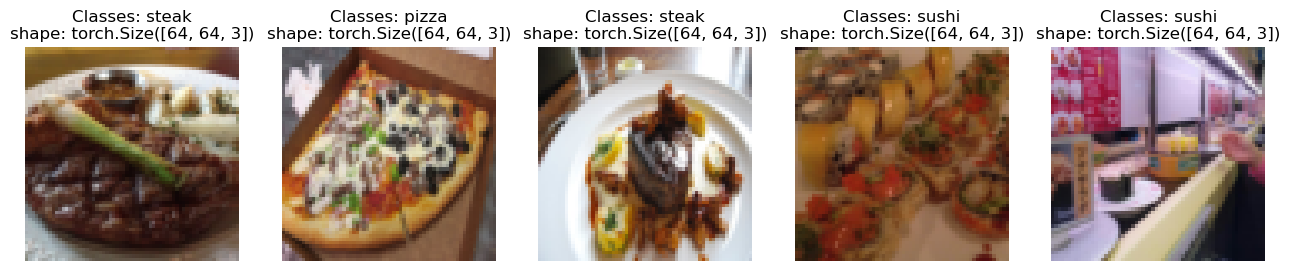

In [40]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      classes=class_names,
                      n=5,
                     seed=None)

For disaplay, purposes, n should'n be large then 10, setting to 10 and removing shape display.


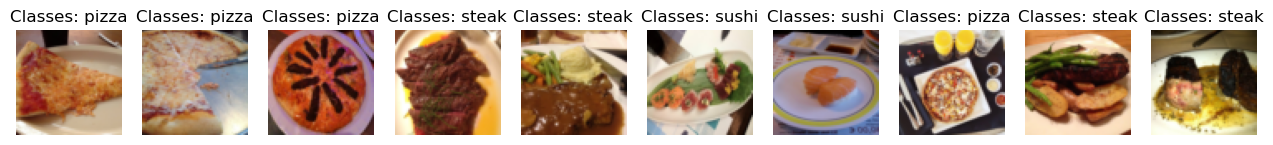

In [41]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(dataset=train_data_custom,
                      n=12,
                      classes=class_names,
                      seed=None)

### 5.4 Turn custom loaded images into 'DataLoader'


In [42]:
# turn train and test datasets into DataLoader's 
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                              batch_size=BATCH_SIZE,
                              num_workers=0,       # num of CPUs -> os.cpu_count()
                               shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                             batch_size=BATCH_SIZE,
                             num_workers=0,
                             shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x1a1925d23a0>,
 <torch.utils.data.dataloader.DataLoader at 0x1a1925d2370>)

In [43]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# print out shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (data augmentation)

Data augmentation is the process of aritificially adding diversity to your training data.

**(Looking at the same things but from different perspective)**

Let's take a look at one paricular type of data augmentation used to train PyTorch vision models to state of the art levels..

In [44]:
# Let's look at trivialalaugment
from torchvision import transforms

train_transform = transforms.Compose([
                                        transforms.Resize(size=(224, 224)),
                                        transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                        transforms.ToTensor()
                                    ])

test_transform = transforms.Compose([
                                        transforms.Resize(size=(224, 224)),
                                        transforms.ToTensor()
                                    ])

train_transforms, test_transform

(Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
     RandomHorizontalFlip(p=0.5)
     ToTensor()
 ),
 Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
     ToTensor()
 ))

In [45]:
image_path

WindowsPath('data/pizza_steak_sushi')

In [46]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2124579.jpg')]

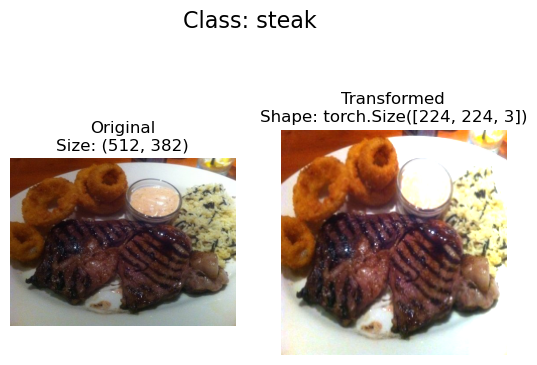

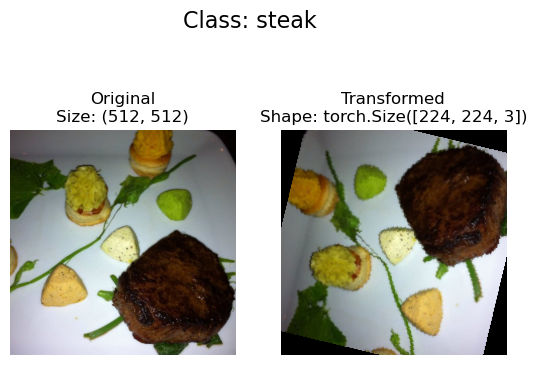

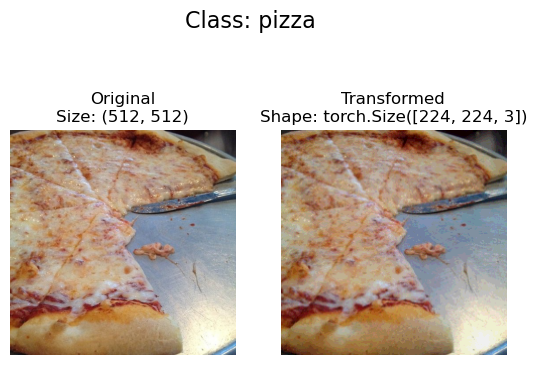

In [47]:
# Plot random transformed Images
plot_transforms_image(image_paths=image_path_list,
                      transform=train_transform, 
                      n=3,
                      seed=None)

## 7. Model 0: TinyVGG without data augmentation 

Let's replicate TinyVGG architecture from the CNN Explainer website

### 7.1 Creating transforms and loading data for Model 0

In [48]:
# Create simple transform
from torchvision import transforms

simple_transform = transforms.Compose([
                                        transforms.Resize(size=(64, 64)),
                                        transforms.ToTensor()
])

In [49]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                       transform=simple_transform)

# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of works
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoader's
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

### 7.2 Create TinyVGG model class

In [50]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1, 
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1, 
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)    # default stride value is same as kernel
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1, 
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1, 
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)    # default stride value is same as kernel
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape)
        )
        
    def forward(self, x):
        x = self.conv_block_1(x)
#         print(x.shape)
        x = self.conv_block_2(x)
#         print(x.shape)
        x = self.classifier(x)
#         print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x)))
        
        

In [51]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,   # number of color channels  in image data
                  hidden_units=10,
                  output_shape=len(class_names))
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Building basline model (dummy model test forward pass and shape)

In [52]:
# Get single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [53]:
# Try forward pass
model_0(image_batch)

tensor([[ 2.0789e-02, -1.9351e-03,  9.5317e-03],
        [ 1.8427e-02,  2.4670e-03,  6.6757e-03],
        [ 1.7699e-02,  1.0262e-03,  9.4657e-03],
        [ 2.4441e-02, -3.3526e-03,  9.6011e-03],
        [ 1.9930e-02,  6.6316e-04,  1.0779e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0999e-02,  1.2869e-04,  1.2473e-02],
        [ 2.1577e-02, -1.9507e-03,  9.6941e-03],
        [ 2.4504e-02, -4.7745e-03,  8.5280e-03],
        [ 2.0252e-02, -4.7292e-04,  1.0908e-02],
        [ 2.2215e-02, -4.1838e-04,  9.8123e-03],
        [ 2.2313e-02, -2.1622e-03,  9.4455e-03],
        [ 2.1841e-02, -3.7132e-03,  8.3783e-03],
        [ 2.2863e-02, -1.7723e-03,  1.0287e-02],
        [ 2.1647e-02, -4.4139e-03,  9.5021e-03],
        [ 2.2096e-02, -4.1426e-03,  9.3853e-03],
        [ 2.1209e-02, -4.4219e-03,  1.1475e-02],
        [ 2.1711e-02, -2.7656e-03,  8.5006e-03],
        [ 1.9951e-02,  2.8258e-05,  8.4380e-03],
        [ 1.8298e-02,  1.6306e-03,  8.5499e-03],
        [ 2.0768e-02

### 7.4 Use 'torchinfo' to get an idea of the shapes going through our model

In [54]:
# intall torchinfo 
# pip install torchinfo

from torchinfo import summary
summary(model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## 7.5 Create train step and test step functions

In [55]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.dataloader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer, 
               device: device):
    # put the model in train model
    model.train()
    
    # Setup train loss and train accuray values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # send data to the target device
        X, y = X.to(device), y.to(device)
        
        # 1. forward pass
        y_pred = model(X)      # output logits 
        
        # 2. calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()   # item() get single integer
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        
        # 4. loss backward
        loss.backward()
        
        # 5. optimizer step 
        optimizer.step()
        
        # calculate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)
        
    # Adjust matrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [56]:
# Creat test step 
def test_step(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             device = device):
    # Put model in eval mode
    model.eval()

    # Setup test loss and  test accuray values
    test_loss, test_acc = 0, 0

    # Turn on inference mode
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            # send data to target device
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred_logits = model(X)
            
            # 2. Calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()  # item() get single integer
            
            # 3. Calculate the accuracy
            test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
            test_acc += (test_pred_labels==y).sum().item()/len(test_pred_labels)
            
        # Adjust metrics to get average loss and accuracy per batch
        test_loss = test_loss / len(dataloader)
        test_acc = test_acc / len(dataloader)
        return test_loss, test_acc

### 7.6 Creating a 'train()' function to combine 'train_step()' and 'test_step()'

In [57]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloader + loss_fn
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.dataloader,
          test_dataloader: torch.utils.data.dataloader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):
    
    # 2. Create empty results dictionary
    results = {"train_loss" : [],
               "train_acc" : [],
               "test_loss" : [],
               "test_acc" : []}
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        # 4. Print our what's happening
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")
 
        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
    # 6. Return the filled results at the end of epochs
    return results

### 7.7 Train and evalute model 0

In [144]:
# Set random seeds
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# set number of epochs
NUM_EPOCHS = 10

# setup loss function and optimizer 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), 
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_timer = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)
# End the timer and print out how long it took
end_timer = timer()
print(f"Total training time: {end_timer - start_timer:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.7765 | Train acc: 0.6562 | Test loss: 0.9993 | Test acc: 0.5350
Epoch: 1 | Train loss: 0.6992 | Train acc: 0.6758 | Test loss: 1.0424 | Test acc: 0.3920
Epoch: 2 | Train loss: 0.7614 | Train acc: 0.7148 | Test loss: 0.9882 | Test acc: 0.4839
Epoch: 3 | Train loss: 0.7349 | Train acc: 0.6680 | Test loss: 1.0244 | Test acc: 0.4233
Epoch: 4 | Train loss: 0.8122 | Train acc: 0.5898 | Test loss: 1.0515 | Test acc: 0.4441
Epoch: 5 | Train loss: 0.6642 | Train acc: 0.7188 | Test loss: 0.9988 | Test acc: 0.4441
Epoch: 6 | Train loss: 0.6834 | Train acc: 0.7266 | Test loss: 0.9991 | Test acc: 0.4962
Epoch: 7 | Train loss: 0.6690 | Train acc: 0.7422 | Test loss: 1.0298 | Test acc: 0.4858
Epoch: 8 | Train loss: 0.6431 | Train acc: 0.7305 | Test loss: 1.0155 | Test acc: 0.5758
Epoch: 9 | Train loss: 0.6937 | Train acc: 0.6250 | Test loss: 1.0994 | Test acc: 0.4337
Total training time: 90.540 seconds


In [146]:
model_0_results

{'train_loss': [0.7765088900923729,
  0.6992438696324825,
  0.7613696530461311,
  0.7348925024271011,
  0.8121776282787323,
  0.6641770899295807,
  0.6834097541868687,
  0.668973796069622,
  0.6431479230523109,
  0.6937464401125908],
 'train_acc': [0.65625,
  0.67578125,
  0.71484375,
  0.66796875,
  0.58984375,
  0.71875,
  0.7265625,
  0.7421875,
  0.73046875,
  0.625],
 'test_loss': [0.999302864074707,
  1.0424036582310994,
  0.988217830657959,
  1.0244474808375041,
  1.0514723658561707,
  0.9987746278444926,
  0.9991291761398315,
  1.0298481782277424,
  1.0154590209325154,
  1.099432150522868],
 'test_acc': [0.5350378787878788,
  0.3920454545454546,
  0.48390151515151514,
  0.4232954545454546,
  0.4441287878787879,
  0.4441287878787879,
  0.49621212121212127,
  0.4857954545454546,
  0.5757575757575758,
  0.43371212121212127]}

### 7.8 Plotting model 0 loss curves

* Loss curves: loss curves is way of traking model's progress over time.

In [147]:
# Get the model_0_resutls keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [148]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary."""
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    
    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]
    
    # Figure out how many epochs there were
    epochs = range(len(results["train_loss"]))
    
    # setup a plot
    plt.figure(figsize=(15, 7))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_acc")
    plt.plot(epochs, test_accuracy, label="test_acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

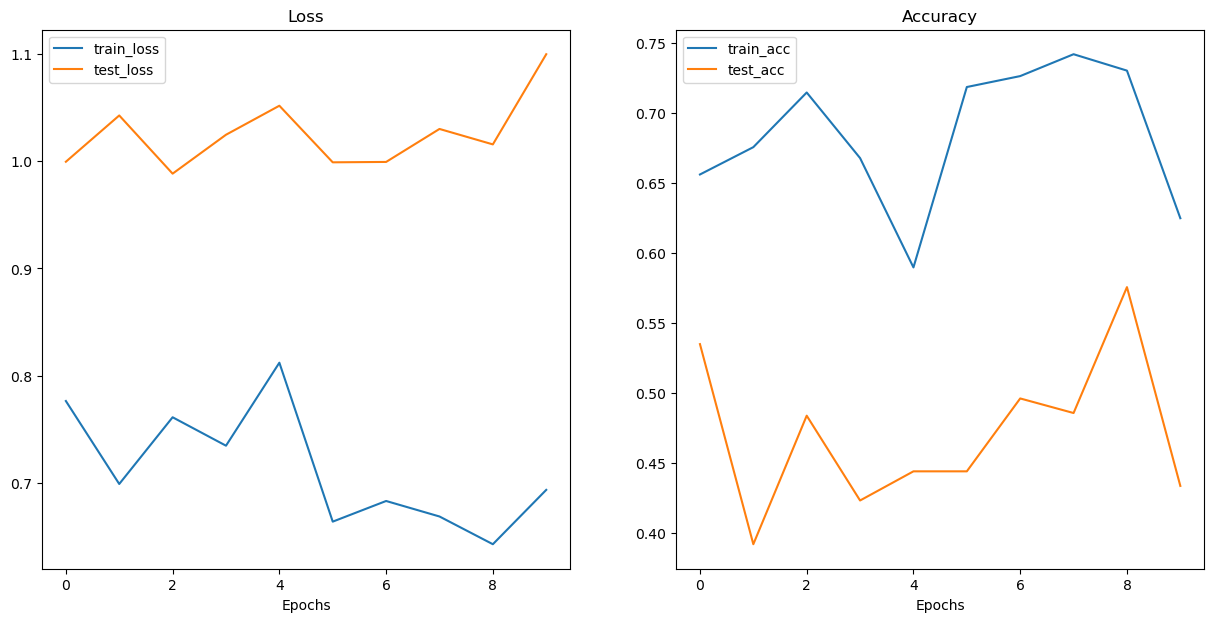

In [149]:
plot_loss_curves(model_0_results)

## 9. Model 1: TinyVGG with Data Augmentation 

### 9.1 Create transform with data augmentation

In [63]:
# Create training transfom with TrivialAugment
from torchvision import transforms
train_transforms_trivial = transforms.Compose([
                                                transforms.Resize(size=(64, 64)),
                                                transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                                transforms.ToTensor()
])

test_transforms_simple = transforms.Compose([
                                                transforms.Resize(size=(64,64)),
                                                transforms.ToTensor()
])

### 9.2 Create train and test 'Dataset' and 'DataLoader' with data augmentation

In [64]:
# Turn image folder into datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transforms_trivial)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transforms_simple)

In [65]:
# Turn our datasets into dataloaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False,
                                       num_workers=NUM_WORKERS)

### 9.3 Consturct and train model 1

In [66]:
# Create model 1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [138]:
# set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 10

# setup loss function 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

# start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model 1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# end the timer
end_time = timer()
print(f"Total training time for model_1 {end_time - start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.9474 | Train acc: 0.5547 | Test loss: 1.0213 | Test acc: 0.3722
Epoch: 1 | Train loss: 1.0501 | Train acc: 0.4414 | Test loss: 1.0177 | Test acc: 0.3314
Epoch: 2 | Train loss: 0.8369 | Train acc: 0.6328 | Test loss: 1.0438 | Test acc: 0.3835
Epoch: 3 | Train loss: 0.9252 | Train acc: 0.6172 | Test loss: 1.0514 | Test acc: 0.3220
Epoch: 4 | Train loss: 0.8572 | Train acc: 0.6133 | Test loss: 1.0818 | Test acc: 0.3116
Epoch: 5 | Train loss: 0.9229 | Train acc: 0.5938 | Test loss: 1.0823 | Test acc: 0.4347
Epoch: 6 | Train loss: 0.8487 | Train acc: 0.6289 | Test loss: 0.9795 | Test acc: 0.4328
Epoch: 7 | Train loss: 0.9051 | Train acc: 0.6172 | Test loss: 0.9626 | Test acc: 0.4223
Epoch: 8 | Train loss: 0.9574 | Train acc: 0.4688 | Test loss: 1.0346 | Test acc: 0.4242
Epoch: 9 | Train loss: 0.8816 | Train acc: 0.4883 | Test loss: 0.9211 | Test acc: 0.5436
Total training time for model_1 91.870 seconds


In [139]:
model_1_results

{'train_loss': [0.9473770782351494,
  1.0500585585832596,
  0.8368575498461723,
  0.9251639917492867,
  0.8572018854320049,
  0.9229224696755409,
  0.848679430782795,
  0.9050895869731903,
  0.9574132338166237,
  0.8815929964184761],
 'train_acc': [0.5546875,
  0.44140625,
  0.6328125,
  0.6171875,
  0.61328125,
  0.59375,
  0.62890625,
  0.6171875,
  0.46875,
  0.48828125],
 'test_loss': [1.021251142024994,
  1.017705261707306,
  1.0437972942988079,
  1.0514333446820576,
  1.081785003344218,
  1.0823190609614055,
  0.9795393149058024,
  0.9625760515530905,
  1.0345871249834697,
  0.921126127243042],
 'test_acc': [0.3721590909090909,
  0.331439393939394,
  0.3835227272727273,
  0.32196969696969696,
  0.31155303030303033,
  0.4346590909090909,
  0.43276515151515155,
  0.42234848484848486,
  0.42424242424242425,
  0.5435606060606061]}

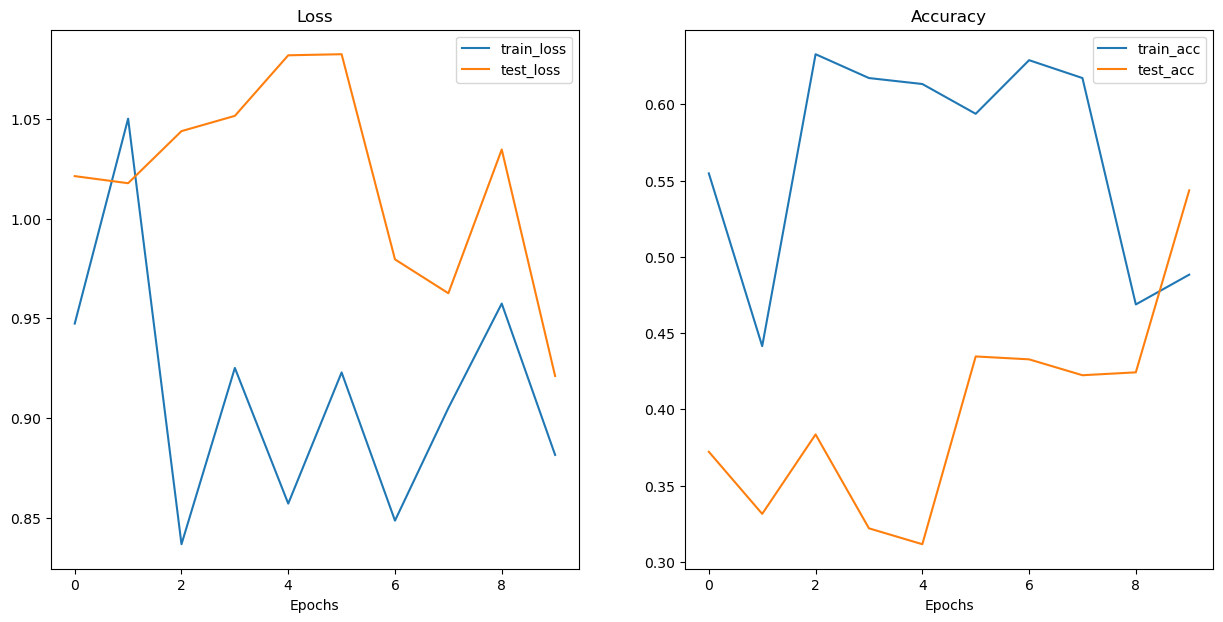

In [140]:
plot_loss_curves(model_1_results)

## 10. Compare model resuts

After evaluating our modelling experiments on thier own, it's important to compare them to each other.
There's few different ways to do this:

    1. Hard coding (what we're doing)
    2. PyTorch + Tensorboard 
    3. Weights & Biases
    4. MLFlow

In [150]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,0.776509,0.656250,0.999303,0.535038
1,0.699244,0.675781,1.042404,0.392045
2,0.761370,0.714844,0.988218,0.483902
3,0.734893,0.667969,1.024447,0.423295
4,0.812178,0.589844,1.051472,0.444129
5,0.664177,0.718750,0.998775,0.444129
6,0.683410,0.726562,0.999129,0.496212
7,0.668974,0.742188,1.029848,0.485795
8,0.643148,0.730469,1.015459,0.575758
9,0.693746,0.625000,1.099432,0.433712


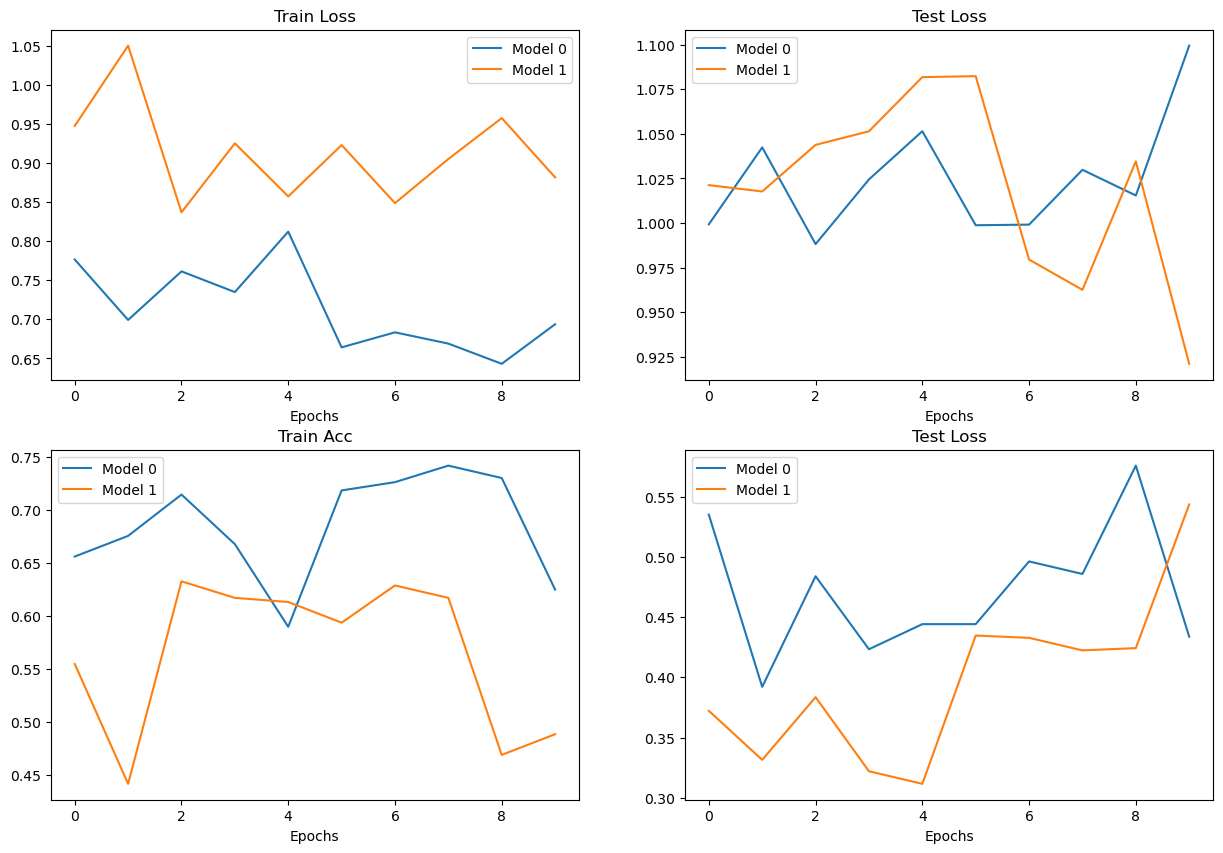

In [151]:
# setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train acc
plt.subplot(2,2,3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Acc")
plt.xlabel("Epochs")
plt.legend()

# Plot test acc
plt.subplot(2,2,4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend();

## 11 Making a predition on a custom image
Predition on sample/image that's not in either training or testing dataset.


In [86]:
# Download custom image
import requests

# setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # when downloading from Github, need to use the raw file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download....")

### 11.1 Loading in a custom image with pytorch

We have to make sure our custom image is in the same format as the data our model was trained on.

    * In tensor form with datatype (troch.float32)
    * Of shape 64x64x3 
    * On the right device

In [88]:
custom_image_path

WindowsPath('data/04-pizza-dad.jpeg')

In [96]:
import torchvision 

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

print(custom_image_uint8)
print(custom_image_uint8.shape)
print(custom_image_uint8.dtype)

tensor([[[154, 175, 181,  ...,  21,  18,  14],
         [146, 167, 180,  ...,  21,  18,  15],
         [124, 146, 171,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 189, 193,  ...,  22,  19,  15],
         [163, 181, 194,  ...,  22,  19,  16],
         [141, 163, 185,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 106, 104, 102],
         [ 47,  38,  24,  ..., 108, 105, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[117, 138, 145,  ...,  17,  14,  10],
         [109, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  54,  52,  50],
         [ 27,  18,   4,  ...,  50,  47,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
torch.Size([3, 4032, 3024])
torch.uint8


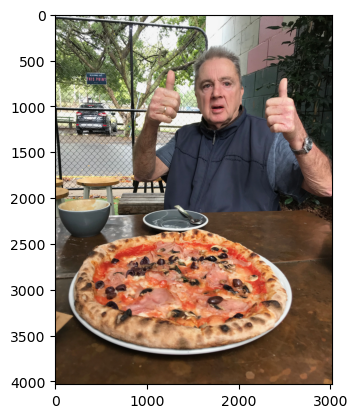

In [95]:
plt.imshow(custom_image_uint8.permute(1,2,0))

### 11.2 Making a predicion on a custom image with a trained pytoch model



In [99]:
# Try to make a predition on an image in unit8 format
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_uint8.to(device))

RuntimeError: expected scalar type Byte but found Float

In [104]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) /255.
custom_image

tensor([[[0.6039, 0.6863, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6549, 0.7059,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6706,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7412, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7098, 0.7608,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7255,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4157, 0.4078, 0.4000],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4118, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4588, 0.5412, 0.5686,  ..., 0.0667, 0.0549, 0.0392],
         [0.4275, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

In [103]:
model_1.eval()
with torch.inference_mode():
    model_1(custom_image.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x756765 and 1690x3)

In [108]:
# Create trasnform pipline to resize image
from torchvision import transforms

custom_image_transform = transforms.Compose([
                                                transforms.Resize(size=(64,64))
])

# Transfrom target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out the shapes
print(custom_image.shape)
print(custom_image_transformed.shape)

torch.Size([3, 4032, 3024])
torch.Size([3, 64, 64])


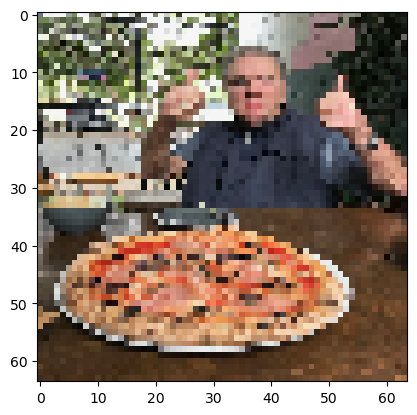

In [110]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [152]:
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x169 and 1690x3)

In [153]:
custom_image_transformed.shape, custom_image_transformed.unsqueeze(0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [154]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred

tensor([[-0.0745, -0.7240, -0.6580]])

In [155]:
# Convert logits -> predicion probabilites
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.4807, 0.2511, 0.2682]])

In [156]:
# pred probs -> pred labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
class_names[custom_image_pred_label]

'pizza'

### 11.3 Putting custom image prediction together: building a function

Ideal outcome:
A function where we pass an image path to and have our model predict on that image and plot the image + prediction.

In [158]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device=device):
    """Make a predition on a target image with model and plot the image and predition."""
    # Load in image
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    # devide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.
    
    # Transforms if necessary
    if transforms:
        target_image = transform(target_image)
        
    # Make sure the model is on the target device
    model.to(device)
    
    # Turn eval/inference mode and make predition
    model.eval()
    with torch.inference_mode():
        # add extra dimention to the image
        target_image_pred = model(target_image.unsqueeze(0).to(device))  # make sure target image is on right device
    
    # logits -> pred probs
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    # pred probs -> labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # Plot image alongside the prediction and prediction proba
    plt.imshow(target_image.squeeze().permute(1,2,0)) # remove batch dimension and rearrage shape [h,w,c]
    if class_names:
        title = f"Pred : {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred : {target_image_pred_prob} | prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)
    
    

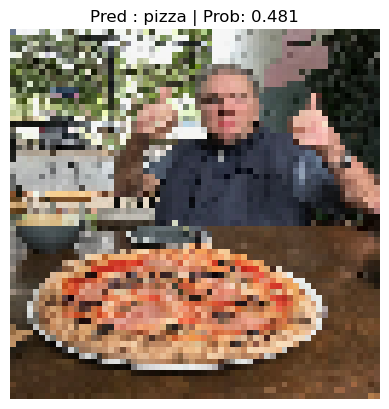

In [159]:
# pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)